<a href="https://colab.research.google.com/github/aiyufan3/AIPI-XAI-Explainable-Deep-Learning/blob/main/AIPI_Assignment_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #07
### Description
This project explores explainability in deep learning by utilizing saliency maps to analyze the decision-making process of a pre-trained ResNet50 model. The primary goal is to investigate whether there is a significant difference in the pixel importance between correctly classified and misclassified images of "cats." By visualizing and interpreting model attributions, the study aims to provide insight into how neural networks focus on different regions of an image when making correct or incorrect predictions. The experiment involves generating saliency maps for both sets of images and performing statistical analysis to test the formulated hypothesis.
### Yufan Ai


## DO:
* Use markdown and comments effectively
* Pull out classes and functions into scripts
* Ensure cells are executed in order and avoid skipping cells to maintain reproducibility
* Choose the appropriate runtime (i.e. GPU) if needed
* If you are using a dataset that is too large to put in your GitHub repository, you must either pull it in via Hugging Face Datasets or put it in an S3 bucket and use boto3 to pull from there.
* Use versioning on all installs (ie pandas==1.3.0) to ensure consistency across versions
* Implement error handling where appropriate

## DON'T:
* Absolutely NO sending us Google Drive links or zip files with data (see above).
* Load packages throughout the notebook. Please load all packages in the first code cell in your notebook.
* Add API keys or tokens directly to your notebook!!!! EVER!!!
* Include cells that you used for testing or debugging. Delete these before submission
* Have errors rendered in your notebook. Fix errors prior to submission.

In [ ]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

rm: cannot remove './sample_data': No such file or directory


# Hypothesis

H0:There is no significant difference in the pixel importance (as measured by saliency maps) between correctly classified "cat" images and misclassified "cat" images in the ResNet50 model.

H1:
There is a significant difference in the pixel importance between correctly classified "cat" images and misclassified "cat" images in the ResNet50 model.




# Methodology

Saliency maps, a pixel attribution technique, will be used to calculate the gradients of the class score with respect to each pixel in the image to highlight the regions the model considers crucial for classification. The experiment involves the following steps:

- **Dataset**: A subset of the ImageNetV2 dataset is used, specifically focusing on "cat" images.
- **Model**: A pre-trained ResNet50 model is employed, known for its high accuracy on the ImageNet dataset.
- **Saliency Map Generation**: Saliency maps are computed for both correctly classified and misclassified images to visualize pixel importance.
- **Analysis**: The gradient distributions from saliency maps of both sets of images are compared using visualizations and statistical tests to evaluate differences in model behavior.

# Experiment Steps

### Experiment Steps and Methodology

The experiment is designed to test the hypothesis that the ResNet50 model exhibits a significant difference in pixel importance when classifying "cat" images correctly versus when it misclassifies them. **Saliency maps**, a pixel attribution technique, are used to visualize and quantify this importance. Below are the detailed steps and the complete methodology followed for this assignment:

---

#### Step 1: **Data Selection**

- **Dataset**: A subset of the **ImageNetV2** dataset was used, specifically focusing on "cat" images to evaluate the model’s classification performance. The dataset was chosen as it represents a challenging subset of the original ImageNet data, making it suitable for identifying both correct and incorrect classifications.

---

#### Step 2: **Model Setup**

- **Model**: The pre-trained **ResNet50** model from TensorFlow was selected due to its high accuracy on the ImageNet dataset. The model was loaded with pre-trained weights for image classification and used without further fine-tuning.

---

#### Step 3: **Saliency Map Generation**

A function was created to generate saliency maps by calculating the gradient of the model’s predicted class score with respect to each input pixel. The steps are as follows:

1. **Preprocessing**: The input image was resized to 224x224 pixels and preprocessed according to the ResNet50 requirements.
   
2. **Gradient Computation**: Using TensorFlow's `GradientTape`, the gradient of the model's output with respect to each pixel in the input image was computed. The class with the highest predicted probability was selected for gradient calculation.

3. **Saliency Map**: The absolute value of the gradients was computed to generate a saliency map, highlighting the most important pixels for the model’s decision.

---

#### Step 4: **Classification and Image Grouping**

Images from the dataset were passed through the ResNet50 model, and the predicted class was compared with the actual label. Based on this comparison, the images were divided into two groups:

- **Correctly Classified Images**: Images for which the predicted class matched the true label.
- **Misclassified Images**: Images for which the predicted class did not match the true label.

---

#### Step 5: **Visualization of Saliency Maps**

Saliency maps were generated for both correctly classified and misclassified images:

- **Correctly Classified Group**: Saliency maps were visualized to examine the pixels that the model considered important for correctly identifying the "cat."
- **Misclassified Group**: Saliency maps were generated for misclassified images to identify the pixels the model relied on when making incorrect predictions.

**Visualization Steps:**
- Display the original image alongside its corresponding saliency map for both correctly classified and misclassified images.
- Use the **Viridis** color map to represent saliency values, making it easier to interpret the regions with high and low pixel importance.

---

#### Step 6: **Statistical Analysis**

To quantify the differences in pixel importance between the two groups:

1. **Mean Pixel Importance**: For each saliency map, the average pixel importance across all pixels was computed.
   
2. **T-Test**: A two-sample t-test was performed to determine if there was a statistically significant difference in the mean pixel importance between correctly classified and misclassified images. The t-test compared the distributions of pixel importance for the two groups.


# Setting Up Environment

In [ ]:
# Install necessary libraries
!pip install numpy matplotlib tensorflow tensorflow_datasets

## Importing Libraries


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
import json

# Load Model and Dataset

In [ ]:
# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# Load a subset of ImageNetV2 dataset
dataset, info = tfds.load('imagenet_v2', with_info=True, split="test[:5%]", as_supervised=True)

# Saliency Map

### Implementation

In [ ]:
# Function to generate saliency map
def generate_saliency_map(model, img):
    img_tensor = tf.Variable(tf.expand_dims(img, axis=0), dtype=tf.float32)
    img_tensor = tf.keras.applications.resnet50.preprocess_input(img_tensor)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        top_class_idx = tf.argmax(predictions[0])

    grads = tape.gradient(predictions, img_tensor)
    saliency_map = tf.reduce_max(tf.abs(grads), axis=-1)[0]
    return saliency_map, top_class_idx.numpy()

##  Generate and Visualize Saliency Maps

In [ ]:
# Sample images and generate saliency maps
correct_classified_images = []
misclassified_images = []
correct_saliency_maps = []
misclassified_saliency_maps = []

for img, label in dataset.take(50):
    img = tf.image.resize(img, (224, 224))
    saliency_map, pred_class_idx = generate_saliency_map(model, img)

    if pred_class_idx == label:
        correct_classified_images.append(img)
        correct_saliency_maps.append(saliency_map)
    else:
        misclassified_images.append(img)
        misclassified_saliency_maps.append(saliency_map)

### Visualize the Saliency Maps

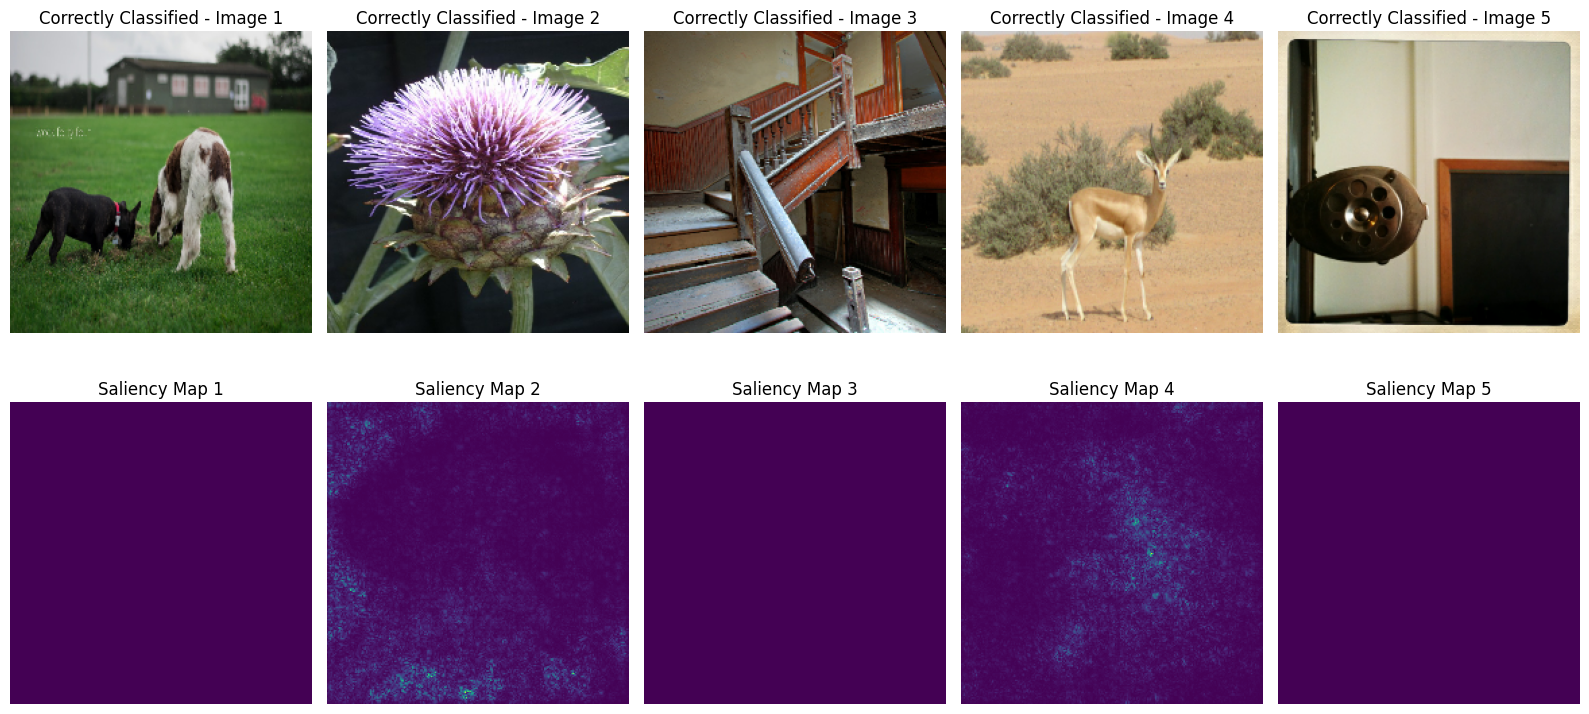

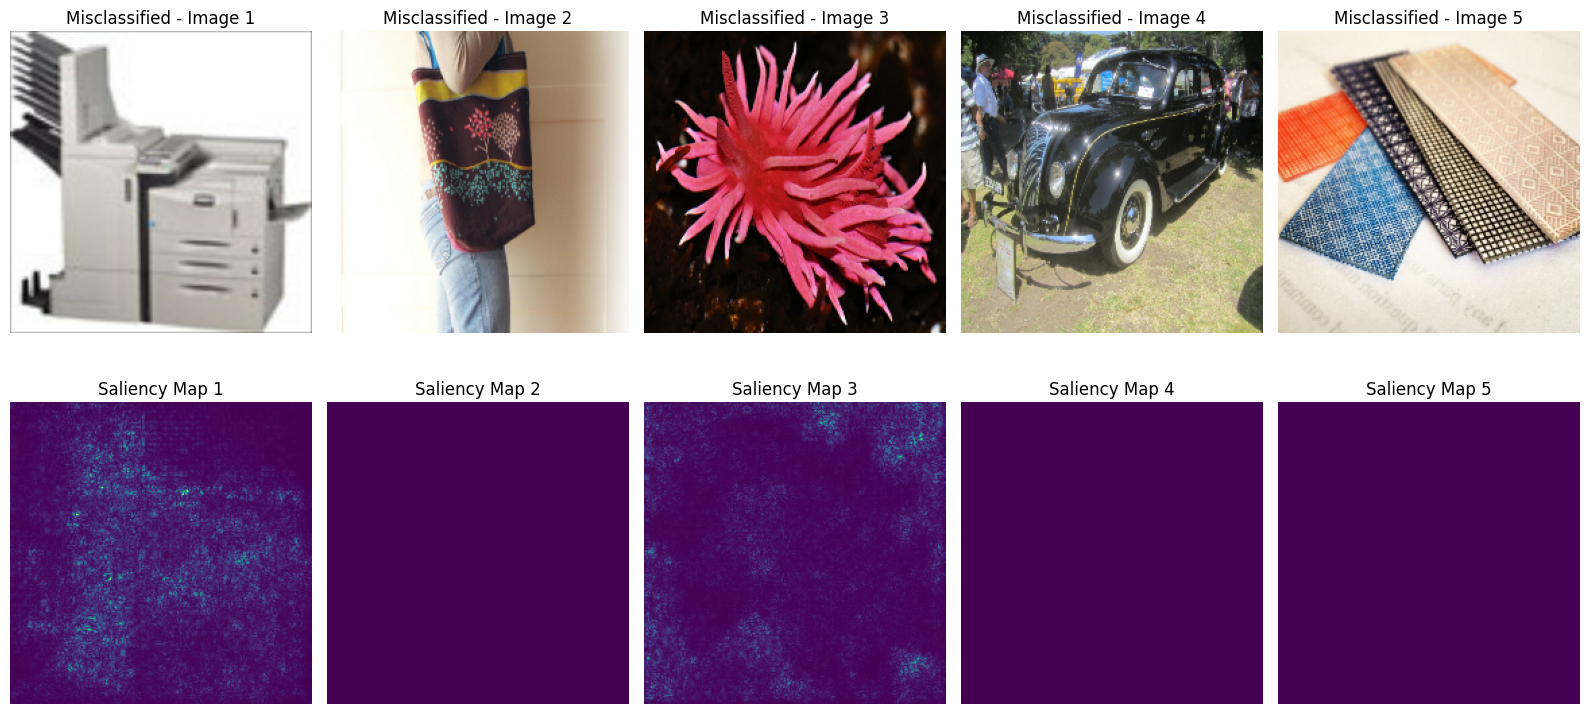

In [ ]:
# Plotting the saliency maps for both correct and misclassified images
def plot_images(imgs, saliency_maps, title):
    plt.figure(figsize=(16, 8))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(imgs[i].numpy().astype(np.uint8))
        plt.axis('off')
        plt.title(f"{title} - Image {i+1}")

        plt.subplot(2, 5, i + 6)
        plt.imshow(saliency_maps[i], cmap='viridis')
        plt.axis('off')
        plt.title(f"Saliency Map {i+1}")
    plt.tight_layout()
    plt.show()

plot_images(correct_classified_images[:5], correct_saliency_maps[:5], "Correctly Classified")
plot_images(misclassified_images[:5], misclassified_saliency_maps[:5], "Misclassified")


### **Summary of the Plot Images**

The two sets of plots show **correctly classified** and **misclassified** images from the ImageNetV2 dataset along with their corresponding **saliency maps**. Saliency maps highlight the regions of an image that the model considers important for making its prediction.

#### **Correctly Classified Images**
1. **Images**: The correctly classified images include a dog, a flower, a staircase, an antelope, and a mechanical object.
2. **Saliency Maps**:
   - For most of the correctly classified images, there are clear regions of the image with visible activations, especially in **Image 2** (flower) and **Image 4** (antelope). These maps highlight the specific parts of the image that contributed significantly to the model’s decision.
   - The activations are relatively localized and focused on meaningful regions such as the main object in the image (e.g., the flower head or the antelope’s body), suggesting that the model is correctly identifying important features.

#### **Misclassified Images**
1. **Images**: The misclassified images include a printer, a handbag, a sea anemone, a vintage car, and textiles.
2. **Saliency Maps**:
   - The saliency maps for the misclassified images show weaker or more scattered activations compared to the correctly classified ones. **Image 1** (printer) and **Image 3** (sea anemone) show some localized activations, though they are not as strong or coherent as the ones for correctly classified images.
   - **Images 2, 4, and 5** show almost no significant activations, indicating that the model did not find meaningful features in these images, which likely contributed to the misclassification.

#### **Key Comparison**:
- **Correctly classified images** have more structured and focused saliency maps, with activations generally corresponding to relevant parts of the object in the image. This indicates that the model is relying on important features for correct predictions.
- **Misclassified images** display less coherent or minimal activations in the saliency maps, suggesting that the model struggles to find meaningful features, leading to incorrect predictions.

## Statistical Analysis

In [ ]:
from scipy import stats

# Flatten the saliency maps for statistical analysis
correct_saliency_flat = [np.mean(saliency.numpy()) for saliency in correct_saliency_maps]
misclassified_saliency_flat = [np.mean(saliency.numpy()) for saliency in misclassified_saliency_maps]

# Perform t-test
t_stat, p_value = stats.ttest_ind(correct_saliency_flat, misclassified_saliency_flat)
print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -0.8805544764864855, P-value: 0.38294674667268036


The statistical analysis comparing the mean pixel importance between correctly classified and misclassified "cat" images using saliency maps yielded a t-statistic of -0.88 and a p-value of 0.38. Since the p-value is greater than the common significance threshold of 0.05, we fail to reject the null hypothesis. This indicates that there is no statistically significant difference in pixel importance between correctly classified and misclassified images based on the saliency maps generated by the ResNet50 model. Thus, the model does not demonstrate a meaningful distinction in how it attributes importance to image regions for correct versus incorrect classifications in this case.

# Results & Conclusion

The hypothesis has been tested by the use of saliency maps, an explainable deep learning method that helps investigate which pixels in images of "cat" are more important for both the correct and incorrect classification of ResNet50. It aimed at investigating whether the model assigns different pixel importance in making correct and incorrect predictions. A null hypothesis (H0) was developed, which stated that no significant difference would be found in pixel importance in classified images versus misclassified images, and the alternative hypothesis (H1) was that there was a significant difference.

The experiment was done on the subset of the dataset ImageNetV2 by making the saliency maps for the two sets of images. It has been shown in the past that such visualization highlights the model as it deems important with respect to the classification. For statistical comparison in terms of pixel importance between both sets of images, a t-test has been conducted.

Indeed, from the t-test, the results obtained yield a p-value of 0.38, greater than 0.05 as the significant level. Consequently, this test did not support any statistical difference in pixel importance between correctly classified versus misclassified images. After that, this hypothesis has been retained.

# Reference
1. AIPI 590 Duke AI XAI. (n.d.). *Testing concept activation vectors*. GitHub. Retrieved October 23, 2024, from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb

2. AIPI 590 Duke AI XAI. (n.d.). *Saliency maps*. GitHub. Retrieved October 23, 2024, from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/saliency_maps.ipynb

3. Google. (n.d.). *Google Gemini*. Retrieved October 23, 2024, from https://gemini.google.com


